<a href="https://colab.research.google.com/github/Victor-Manach/numerai/blob/main/numerai_rank_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q numerapi

In [2]:
!pip install -q --no-deps numerai-tools

In [3]:
from typing import List, Dict, Any, Literal, Optional, Tuple, Callable
from pathlib import Path
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass
import math
from torch.utils.data import TensorDataset, DataLoader, Dataset, Sampler
import time
import matplotlib.pyplot as plt
import seaborn as sns

from numerai_tools.scoring import numerai_corr, correlation_contribution
from tqdm.notebook import tqdm

import h5py

plt.rcParams["figure.figsize"] = (10, 5)

In [4]:
path_to_drive = Path('/content/drive/My Drive')

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")

device='cuda'


In [6]:
DATA_VERSION = "v5.0"
MODEL_NAME = "RANK_MLP_SMALL"
PATH_TO_DATA = path_to_drive / f"numerai/data/{DATA_VERSION}"
SKIP_TRAINING = False

In [7]:
features_path = PATH_TO_DATA / "features.json"
TRAIN_PATH = PATH_TO_DATA / "train/train_v2.h5"
VALID_PATH = PATH_TO_DATA / "valid/valid_v2.h5"

MODEL_PATH = path_to_drive / f"numerai/models"

In [8]:
feature_metadata = json.load(open(features_path))
all_target_cols = feature_metadata["targets"]
feature_sets = feature_metadata["feature_sets"]

sm_feature_set = feature_sets["small"]
med_feature_set = feature_sets["medium"]
all_feature_set = feature_sets["all"]

ERA_COL = "era"
MAIN_TARGET = "target"
AUXILIARY_TARGETS = [
  "target_victor_20",
  "target_xerxes_20",
  "target_teager2b_20",
  "target_caroline_20",
  "target_sam_20",
  "target_echo_20",
  "target_alpha_20",
  "target_jeremy_20"
]

feature_set = med_feature_set

In [9]:
def load_features_id(features_to_use, h5_file):
    feature_to_id_file = h5_file.parent / "feature_to_id.json"
    with open(feature_to_id_file, 'r') as f:
        feature_to_id = json.load(f)
    features_id = [feature_to_id[f] for f in features_to_use]

    return features_id

def load_targets_id(targets_to_use, h5_file):
    target_to_id_file = h5_file.parent / "target_to_id.json"
    with open(target_to_id_file, 'r') as f:
        target_to_id = json.load(f)
    targets_id = [target_to_id[t] for t in targets_to_use]

    return targets_id

def load_target_id(target_to_use, h5_file):
    target_to_id_file = h5_file.parent / "target_to_id.json"
    with open(target_to_id_file, 'r') as f:
        target_to_id = json.load(f)
    target_id = target_to_id[target_to_use]

    return target_id

def load_eras_data(keep_eras, h5_file, target_to_use=None):
    if target_to_use is not None:
        target_id = load_target_id(target_to_use, h5_file)
    else:
        target_id = None
    era_vector = []
    with h5py.File(h5_file, 'r') as f:
        era_ix = f['era_index']
        idx_list = []
        if keep_eras is not None:
            for era in keep_eras:
                era_key = str(era).zfill(4)
                if era_key in era_ix:
                    idx_list.append(era_ix[era_key][:])
                    era_vector.append([era]*len(era_ix[era_key]))
            if idx_list:
                indices = np.concatenate(idx_list)
            else:
                indices = np.array([], dtype=np.int64)
            features = f['features'][indices, :]
        else:
            features = f['features'][:]

        if target_id is not None:
            if keep_eras is not None:
                targets = f['targets'][indices, target_id]
            else:
                targets = f['targets'][:, target_id]
        else:
            if keep_eras is not None:
                targets = f['targets'][indices, :]
            else:
                targets = f['targets'][:]

    era_vector = np.concatenate(era_vector)
    return features, targets, era_vector

def load_first_n_eras_data(n, h5_file, target_to_use=None):
    if target_to_use is not None:
        target_id = load_target_id(target_to_use, h5_file)
    else:
        target_id = None

    era_vector = []
    with h5py.File(h5_file, 'r') as f:
        era_ix = f['era_index']
        era_keys = sorted(list(era_ix.keys()))
        first_n_keys = era_keys[:n]
        idx_list = []
        for era_key in first_n_keys:
            idx_list.append(era_ix[era_key][:])
            era_vector.append([int(era_key)]*len(era_ix[era_key]))
        if idx_list:
            indices = np.concatenate(idx_list)
        else:
            indices = np.array([], dtype=np.int64)
        features = f['features'][indices, :]
        if target_id is not None:
            targets = f['targets'][indices, target_id]
        else:
            targets = f['targets'][indices, :]

    era_vector = np.concatenate(era_vector)
    return features, targets, era_vector, [int(e) for e in first_n_keys]


def load_eras_data_and_filter_columns(keep_eras, h5_file, features_to_use, target_to_use=None):
    features, targets, era_vector = load_eras_data(keep_eras, h5_file, target_to_use)
    features_id = load_features_id(features_to_use, h5_file)

    return features[:, features_id], targets, era_vector

def load_first_n_eras_data_and_filter_columns(n, h5_file, features_to_use, target_to_use=None):
    features, targets, era_vector, first_n_eras = load_first_n_eras_data(n, h5_file, target_to_use)
    features_id = load_features_id(features_to_use, h5_file)

    return features[:, features_id], targets, era_vector, first_n_eras

In [10]:
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset
    dataset.f = h5py.File(dataset.file_path, "r")

In [11]:
class EfficientEraDataset(Dataset):
    def __init__(self, file_path, eras, feature_columns, target_to_use, aux_targets=None):
        self.file_path = file_path
        self.eras = eras
        self.feature_columns = feature_columns

        self.target_id = load_target_id(target_to_use, self.file_path) if target_to_use is not None else None
        self.features_id = load_features_id(self.feature_columns, self.file_path)
        self.aux_target_ids = load_targets_id(aux_targets, self.file_path) if aux_targets is not None else None

        if self.eras is not None:
            self.load_era_indices()
        else:
            self.load_all_era_indices()

        self.sample_indices = []
        for era, row_ix_array in self.era_to_indices.items():
            for row_ix in row_ix_array:
                self.sample_indices.append((era, row_ix))

        self.f = None

    def load_era_indices(self):
        self.era_to_indices = {}
        with h5py.File(self.file_path, "r") as f:
            era_ix_group = f["era_index"]
            for era in self.eras:
                era_key = str(era).zfill(4)
                if era_key in era_ix_group:
                    row_indices = era_ix_group[era_key][:]
                    self.era_to_indices[era] = row_indices
                else:
                    print(f"Did not find era {era} in {self.file_path}")

    def load_all_era_indices(self):
        self.era_to_indices = {}
        with h5py.File(self.file_path, "r") as f:
            era_ix_group = f["era_index"]
            for era_key in era_ix_group.keys():
                era = int(era_key)
                row_indices = era_ix_group[era_key][:]
                self.era_to_indices[era] = row_indices

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        era, row_ix = self.sample_indices[idx]

        features_np = self.f["features"][row_ix]
        features_np = features_np[self.features_id]
        features_np = (features_np - 2.0) / 2.0

        if self.target_id is not None:
            target_np = self.f["targets"][row_ix, self.target_id]
        else:
            target_np = self.f["targets"][row_ix, :]

        if self.aux_target_ids is not None:
            aux_targets_np = self.f["targets"][row_ix, :]
            aux_targets_np = aux_targets_np[self.aux_target_ids]
        else:
            aux_targets_np = np.array([], dtype=np.float32)

        features = torch.tensor(features_np, dtype=torch.float32)
        target = torch.tensor(target_np, dtype=torch.float32)
        aux_targets = torch.tensor(aux_targets_np, dtype=torch.float32)

        return features, target, aux_targets, era

In [12]:
class InfiniteDataIterator:
    def __init__(self, dataloader, split):
        self.dataloader = dataloader
        self._iterator = iter(dataloader)
        self.split = split

    def __iter__(self):
        return self

    def __next__(self):
        try:
            return next(self._iterator)
        except StopIteration:
            print(f"Restarting data loader ({self.split} split)...")
            self._iterator = iter(self.dataloader)
            return next(self._iterator)

    def reset(self):
        print(f"Resetting data loader ({self.split} split)...")
        self._iterator = iter(self.dataloader)

In [13]:
class PairDataset(Dataset):
    def __init__(self, features, targets, eras, pair_indices):
        self.features = features
        self.targets = targets
        self.eras = eras
        self.pair_indices = pair_indices

    def __len__(self):
        return len(self.pair_indices)

    def __getitem__(self, idx):
        i, j = self.pair_indices[idx]
        f_i = self.features[i]
        f_j = self.features[j]
        t_i = self.targets[i]
        t_j = self.targets[j]
        e_i = self.eras[i]
        e_j = self.eras[j]
        return f_i, f_j, t_i, t_j, e_i, e_j


class SameEraPairSampler(Sampler):
    def __init__(self, eras, max_pairs_per_era, shuffle=True, rng_seed=42):
        self.eras = eras
        self.shuffle = shuffle
        self.pairs = []
        unique_eras = torch.unique(eras)
        rng = np.random.default_rng(rng_seed)

        era_to_indices = {}
        for e in unique_eras:
            era_val = e.item()
            idxs = torch.where(eras==e)[0]
            era_to_indices[era_val] = idxs.tolist()

        for era_val, idxs in era_to_indices.items():
            if len(idxs) < 2:
                continue
            n_pairs = min(max_pairs_per_era, (len(idxs) * (len(idxs) - 1)) // 2)
            pairs_for_era = rng.choice(idxs, size=(n_pairs, 2), replace=True)
            self.pairs.append(pairs_for_era)

        self.pairs = np.vstack(self.pairs)

        if shuffle:
            rng.shuffle(self.pairs)

    def __len__(self):
        return len(self.pairs)

    def __iter__(self):
        for ix in range(len(self.pairs)):
            yield ix


class MultiEraPairsDataset(Dataset):
    def __init__(self, features, targets, eras, max_pairs_per_era, rng_seed=42):
        self.features = features
        self.targets = targets
        self.eras = eras
        self.max_pairs_per_era = max_pairs_per_era
        self.era_to_pairs = self.build_era_to_indices_mapping(rng_seed)

        self.current_pairs = None

    def build_era_to_indices_mapping(self, rng_seed):
        unique_eras = torch.unique(self.eras)
        rng = np.random.default_rng(rng_seed)
        era_to_pairs = {}

        era_to_indices = {}
        for e in unique_eras:
            era_val = e.item()
            idxs = torch.where(self.eras==e)[0]
            era_to_indices[era_val] = idxs.tolist()

        for era_val, idxs in era_to_indices.items():
            if len(idxs) < 2:
                continue
            n_pairs = min(self.max_pairs_per_era, (len(idxs) * (len(idxs) - 1)) // 2)
            pairs_for_era = rng.choice(idxs, size=(n_pairs, 2), replace=True)

            era_to_pairs[era_val] = pairs_for_era

        return era_to_pairs

    def set_era(self, era_val):
        self.current_pairs = self.era_to_pairs[era_val]

    def __len__(self):
        return len(self.current_pairs) if self.current_pairs is not None else 0

    def __getitem__(self, idx):
        i, j = self.current_pairs[idx]
        f_i = self.features[i]
        f_j = self.features[j]
        t_i = self.targets[i]
        t_j = self.targets[j]
        e_i = self.eras[i]
        e_j = self.eras[j]
        return f_i, f_j, t_i, t_j, e_i, e_j


class SingleEraSampler(Sampler):
    def __init__(self, dataset, rng_seed=42):
        self.dataset = dataset
        self.rng = np.random.default_rng(rng_seed)

    def __len__(self):
        return len(self.dataset)

    def __iter__(self):
        n = len(self.dataset)
        for ix in np.arange(n):
            yield ix

In [14]:
# train_eras = [i for i in range(500, 950)]
train_eras = [i for i in range(500, 550)]
x_train_np, y_train_np, train_era_vector_np = load_eras_data_and_filter_columns(train_eras, TRAIN_PATH, feature_set, None)

In [15]:
main_target_id = load_target_id(MAIN_TARGET, TRAIN_PATH)
aux_target_ids = load_targets_id(AUXILIARY_TARGETS, TRAIN_PATH)

y_train_main_np = y_train_np[:, main_target_id]
y_train_aux_np = y_train_np[:, aux_target_ids]

In [16]:
x_train = torch.tensor(x_train_np, dtype=torch.float32)
y_train_main = torch.tensor(y_train_main_np, dtype=torch.float32)
y_train_aux = torch.tensor(y_train_aux_np, dtype=torch.float32)
train_era_vector_pt = torch.tensor(train_era_vector_np, dtype=torch.int32)

x_train.shape, y_train_main.shape, y_train_aux.shape, train_era_vector_pt.shape

(torch.Size([255511, 705]),
 torch.Size([255511]),
 torch.Size([255511, 8]),
 torch.Size([255511]))

In [17]:
train_era_vector_pt.min(), train_era_vector_pt.max()

(tensor(500, dtype=torch.int32), tensor(549, dtype=torch.int32))

In [18]:
x_train = (x_train - 2.0) / 2.0

In [19]:
y_train_main.unique(), y_train_aux.unique()

(tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000]),
 tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,  

In [20]:
x_train = x_train.float()
y_train_main = y_train_main.float()
y_train_aux = y_train_aux.float()

In [21]:
yc = torch.tensor([0., 0.25, 0.5, 0.75, 1.0], dtype=torch.float32)
yc_weights = torch.tensor([1.0, 1.0, 0.2, 1.0, 1.0], dtype=torch.float32)

In [22]:
# n = 150
n = 20
x_valid_np, y_valid_np, valid_era_vector_np, valid_eras = load_first_n_eras_data_and_filter_columns(n, VALID_PATH, feature_set, None)

In [23]:
main_target_id = load_target_id(MAIN_TARGET, VALID_PATH)
aux_target_ids = load_targets_id(AUXILIARY_TARGETS, VALID_PATH)

y_valid_main_np = y_valid_np[:, main_target_id]
y_valid_aux_np = y_valid_np[:, aux_target_ids]

In [24]:
x_valid = torch.tensor(x_valid_np, dtype=torch.float32)
y_valid_main = torch.tensor(y_valid_main_np, dtype=torch.float32)
y_valid_aux = torch.tensor(y_valid_aux_np, dtype=torch.float32)
valid_era_vector_pt = torch.tensor(valid_era_vector_np, dtype=torch.int32)

x_valid.shape, y_valid_main.shape, y_valid_aux.shape, valid_era_vector_pt.shape

(torch.Size([140149, 705]),
 torch.Size([140149]),
 torch.Size([140149, 8]),
 torch.Size([140149]))

In [25]:
valid_era_vector_pt.min(), valid_era_vector_pt.max()

(tensor(975, dtype=torch.int32), tensor(994, dtype=torch.int32))

In [26]:
x_valid = (x_valid - 2.0) / 2.0

In [27]:
y_valid_main.unique(), y_valid_aux.unique()

(tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000]),
 tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,  

In [28]:
x_valid = x_valid.float()
y_valid_main = y_valid_main.float()
y_valid_aux = y_valid_aux.float()

----

In [29]:
class AdapterBlock(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.down_proj = nn.Linear(config.n_embd, config.adapter_dim, bias=config.bias, **factory_kwargs)
        self.up_proj = nn.Linear(config.adapter_dim, config.n_embd, bias=config.bias, **factory_kwargs)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.down_proj(x)
        x = self.gelu(x)
        x = self.up_proj(x)
        return x


class MlpBlock(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.ln = nn.LayerNorm(config.n_embd, **factory_kwargs)
        self.c_fc = nn.Linear(config.n_embd, config.n_embd, bias=config.bias, **factory_kwargs)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias, **factory_kwargs)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.ln(x)
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class MlpBackbone(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.embedding = nn.Linear(config.input_dim, config.n_embd, bias=True, **factory_kwargs)
        self.layers = nn.ModuleList([MlpBlock(config, **factory_kwargs) for _ in range(config.n_layers)])

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x_ffn = layer(x)
            x = x + x_ffn

        return x


class MlpBlockWithAdapter(nn.Module):
    def __init__(self, mlp_block:MlpBlock, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.base_block = mlp_block
        self.adapter_block = AdapterBlock(config, **factory_kwargs)

    def forward(self, x):
        x = x + self.base_block(x)
        x = x + self.adapter_block(x)

        return x


class MlpBackboneWithAdapter(nn.Module):
    def __init__(self, mlp_backbone:MlpBackbone, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        for block in mlp_backbone.layers:
            for name, param in block.named_parameters():
                if "ln" not in name:
                    param.requires_grad = False

        self.embedding = mlp_backbone.embedding
        # for param in self.embedding.parameters():
        #     param.requires_grad = False

        self.mlp_blocks_with_adapter = nn.ModuleList(
            [MlpBlockWithAdapter(mlp_block, config, **factory_kwargs) for mlp_block in mlp_backbone.layers])

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.mlp_blocks_with_adapter:
            x = layer(x)

        return x

class ReconstructionHead(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.proj = nn.Linear(config.n_embd, config.input_dim, bias=True, **factory_kwargs)

    def forward(self, x):
        return self.proj(x)

class RegressionHead(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.main_proj = nn.Linear(config.n_embd, config.main_output_dim, bias=True, **factory_kwargs)
        self.aux_proj = nn.Linear(config.n_embd, config.aux_output_dim, bias=True, **factory_kwargs)

    def forward(self, x):
        return self.main_proj(x), self.aux_proj(x)

In [30]:
class MlpReconstructModel(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone = MlpBackbone(config, **factory_kwargs)
        self.head = ReconstructionHead(config, **factory_kwargs)

        self.config = config

    def forward(self, x):
        x, mask = self.apply_mask(x)
        x = self.backbone(x)

        return self.head(x), mask

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

In [31]:
class MlpRegressionModel(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone = MlpBackbone(config, **factory_kwargs)
        self.head = RegressionHead(config, **factory_kwargs)

        self.config = config

    def forward(self, x):
        x = self.backbone(x)

        return self.head(x)

In [32]:
class MlpReconstructWithAdapterModel(nn.Module):
    def __init__(self, mlp_backbone:MlpBackbone, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone_with_adapter = MlpBackboneWithAdapter(mlp_backbone, config, **factory_kwargs)
        self.head = ReconstructionHead(config, **factory_kwargs)

        self.config = config

    def forward(self, x):
        x, mask = self.apply_mask(x)
        x = self.backbone_with_adapter(x)

        return self.head(x), mask

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

In [33]:
class MlpRegressionWithAdapterModel(nn.Module):
    def __init__(self, mlp_backbone:MlpBackboneWithAdapter, head, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone_with_adapter = mlp_backbone
        self.head = head

        self.config = config

    def forward(self, x):
        x = self.backbone_with_adapter(x)

        return self.head(x)

In [34]:
class MlpReconstructWithAdapterAndConsistency(nn.Module):
    def __init__(self,
                 frozen_backbone: MlpBackbone,
                 backbone_with_adapter: MlpBackboneWithAdapter,
                 config,
                 device=None,
                 dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.config = config

        self.frozen_backbone = frozen_backbone
        for param in self.frozen_backbone.parameters():
            param.requires_grad = False

        self.backbone_with_adapter = backbone_with_adapter
        self.head = ReconstructionHead(config, **factory_kwargs)

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

    def forward(self, x):
        x_masked, mask = self.apply_mask(x)
        h_orig = self.frozen_backbone(x_masked)
        h_adapt = self.backbone_with_adapter(x_masked)
        recon = self.head(h_adapt)

        return recon, mask, h_orig, h_adapt

In [35]:
@dataclass
class Config:
    input_dim: int
    main_output_dim: int
    aux_output_dim: int
    n_layers: int
    n_embd: int
    adapter_dim: int
    dropout: float
    bias: bool
    mask_ratio: float
    noise_std: float

@dataclass
class MlpReconstructConfig:
    input_dim: int
    main_output_dim: int
    aux_output_dim: int
    n_layers: int
    n_embd: int
    dropout: float
    bias: bool
    mask_ratio: float
    noise_std: float

In [36]:
checkpoint = torch.load(MODEL_PATH/f"MLP_RECONSTRUCT.pt", map_location=device, weights_only=False)

In [37]:
config = Config(
    input_dim=len(feature_set),
    main_output_dim=1,
    aux_output_dim=len(AUXILIARY_TARGETS),
    n_layers=4,
    n_embd=256,
    adapter_dim=8,
    dropout=0.5,
    bias=True,
    mask_ratio=0.4,
    noise_std=0.1
)

In [38]:
batch_size = 1024
total_batch_size = 721920 * 2
assert total_batch_size % (batch_size*config.input_dim) == 0
grad_accum_steps = total_batch_size // (batch_size*config.input_dim)
print(f"Total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

Total desired batch size: 1443840
=> calculated gradient accumulation steps: 2


In [39]:
backbone_ckpt = {k:v for (k,v) in checkpoint["model"].items() if "main_proj" not in k}
backbone_for_reg_model_ckpt = {f"backbone.{k}":v for (k,v) in backbone_ckpt.items()}

reconstruct_head_ckpt = {k:v for (k,v) in checkpoint["model"].items() if "main_proj" in k}
reconstruct_head_ckpt = {"head."+k.replace("main_proj", "proj"): v for (k,v) in reconstruct_head_ckpt.items()}

In [40]:
mlp_backbone = MlpBackbone(config).to(device)
# missing_keys, unexpected_keys = mlp_backbone.load_state_dict(backbone_ckpt, strict=False)

# print("Missing keys:", missing_keys)
# print("Unexpected keys:", unexpected_keys)

In [41]:
reg_model = MlpRegressionModel(config).to(device)
# missing_keys, unexpected_keys = reg_model.load_state_dict(backbone_for_reg_model_ckpt, strict=False)

# print("Missing keys:", missing_keys)
# print("Unexpected keys:", unexpected_keys)

In [42]:
def print_trainable_parameters(model):
    n_params = sum(p.numel() for p in model.parameters())
    n_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{model.__class__.__name__}] Number of trainable parameters: {n_params_trainable:,} out of {n_params:,} total parameters.")

In [43]:
print_trainable_parameters(reg_model)

[MlpRegressionModel] Number of trainable parameters: 711,433 out of 711,433 total parameters.


In [44]:
max_steps = 2000
val_loss_n_steps = 200
learning_rate = 6e-4
decay_lr = True
warmup_iters = 40
lr_decay_iters = max_steps # should be ~= max_iters
min_lr = 6e-5 # should be ~= learning_rate/10
weight_decay = 1e-1
betas = (0.9, 0.999)
epsilon = 1e-8
lambda_coef = 10.0
desired_variance = 0.05
gamma = 3.0
n_steps_for_adapter = 80
inference_mini_batch_size = 256

dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
torch.set_float32_matmul_precision("high")

np.random.seed(1337)
torch.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

In [45]:
train_sampler = SameEraPairSampler(train_era_vector_pt, max_pairs_per_era=4000)
train_dataset = PairDataset(x_train, y_train_main, train_era_vector_pt, train_sampler.pairs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

In [46]:
valid_sampler = SameEraPairSampler(valid_era_vector_pt, max_pairs_per_era=3000, shuffle=False)
valid_dataset = PairDataset(x_valid, y_valid_main, valid_era_vector_pt, valid_sampler.pairs)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

In [47]:
len(train_loader), len(valid_loader)

(196, 59)

In [48]:
inference_train_dataset = MultiEraPairsDataset(x_train, y_train_main, train_era_vector_pt, max_pairs_per_era=4000)
inference_train_sampler = SingleEraSampler(inference_train_dataset)
inference_train_loader = DataLoader(inference_train_dataset, batch_size=inference_mini_batch_size, sampler=inference_train_sampler)

In [49]:
inference_valid_dataset = MultiEraPairsDataset(x_valid, y_valid_main, valid_era_vector_pt, max_pairs_per_era=3000)
inference_valid_sampler = SingleEraSampler(inference_valid_dataset)
inference_valid_loader = DataLoader(inference_valid_dataset, batch_size=inference_mini_batch_size, sampler=inference_valid_sampler)

In [50]:
def configure_optimizer(model, weight_decay, learning_rate, betas, device_type, print_):
    param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2] # all weight tensors in matmuls + embeddings decay
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2] # all biases and layernorms

    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    if print_:
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

    use_fused = (device_type == 'cuda')
    extra_args = dict(fused=True) if use_fused else dict()

    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
    if print_:
        print(f"using fused AdamW: {use_fused}")

    return optimizer

In [51]:
reg_optimizer = configure_optimizer(reg_model, weight_decay, learning_rate, betas, device, print_=True)

num decayed parameter tensors: 11, with 707,072 parameters
num non-decayed parameter tensors: 19, with 4,361 parameters
using fused AdamW: True


In [52]:
def get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * (it + 1) / (warmup_iters + 1)
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

get_lr_with_default_values = lambda it: get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr)

In [53]:
def masked_mse_loss(pred, target, mask):
    return ((pred - target)**2 * mask.float()).sum() / mask.float().sum().clamp_min(epsilon)

def masked_mse_loss_with_consistency(pred, target, mask, h_orig, h_adapt, lambda_):
    consistency_loss = F.mse_loss(h_adapt, h_orig)
    return masked_mse_loss(pred, target, mask) + lambda_ * consistency_loss

In [54]:
def pairwise_logistic_loss(preds_i, preds_j, targets_i, targets_j):
    preds_i = preds_i.view(-1)
    preds_j = preds_j.view(-1)
    targets_i = targets_i.view(-1)
    targets_j = targets_j.view(-1)

    mask = (targets_i != targets_j)
    sign = torch.sign(targets_i - targets_j)
    diff = preds_i - preds_j
    loss = -torch.log(F.sigmoid(sign * diff)) * mask.float()
    return loss.sum() / mask.float().sum().clamp_min(1e-8)

In [55]:
@torch.no_grad()
def run_regression_eval_loop(model, valid_loader_iter, n_valid_steps, loss_fn):
    model.eval()
    valid_loader_iter.reset()
    val_loss_accum = 0.0
    for _ in range(n_valid_steps):
        xb1, xb2, yb1, yb2, _, _ = next(valid_loader_iter)
        xb1, xb2, yb1, yb2 = xb1.to(device), xb2.to(device), yb1.to(device), yb2.to(device)
        with torch.autocast(device_type=device, dtype=dtype):
            preds_i, _ = model(xb1)
            preds_j, _ = model(xb2)
            loss = loss_fn(preds_i, preds_j, yb1, yb2)
        loss = loss / n_valid_steps
        val_loss_accum += loss.detach()

    return val_loss_accum

In [56]:
def train_adapter_on_dataset(mlp_backbone, config, loader_iter, n_steps, grad_accum_steps, loss_fn):
    backbone = MlpBackbone(config).to(device)
    backbone.load_state_dict(mlp_backbone.state_dict())

    backbone_with_adapter = MlpBackboneWithAdapter(backbone, config)
    model = MlpReconstructWithAdapterAndConsistency(backbone, backbone_with_adapter, config).to(device)

    # display_pt_model_params(model)

    optimizer = configure_optimizer(model, weight_decay, learning_rate, betas, device, print_=False)

    model.train(True)
    loader_iter.reset()

    for step in range(n_steps):
        last_step = (step == n_steps - 1)
        t0 = time.time()
        optimizer.zero_grad()
        loss_accum = 0.0
        for micro_step in range(grad_accum_steps):
            xb1, xb2, _, _, _, _ = next(valid_loader_iter)
            xb1, xb2 = xb1.to(device), xb2.to(device)

            with torch.autocast(device_type=device, dtype=dtype):
                xb_hat, mask, h_orig, h_adapt = model(xb1)
                loss = loss_fn(xb_hat, xb1, mask, h_orig, h_adapt, lambda_=0.2)

            loss = loss / grad_accum_steps
            loss_accum += loss.detach()
            loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t1 = time.time()
        dt = t1 - t0
        if step % 10 == 0 or last_step:
            print(f"[{model.__class__.__name__}] step {step+1:3d}/{n_steps:3d} | loss={loss_accum.item():.6f} | lr={learning_rate:.6e} | norm={norm:.4f} | dt={dt*1000:.2f}ms")

    return model

In [57]:
def run_eval_loop_with_adapter(model, valid_loader_iter, config, n_steps, n_valid_steps):
    adapter_model = train_adapter_on_dataset(model.backbone, config, valid_loader_iter, n_steps, 1, masked_mse_loss_with_consistency)
    reg_model_with_adapter = MlpRegressionWithAdapterModel(adapter_model.backbone_with_adapter, model.head).to(device)
    val_loss = run_regression_eval_loop(reg_model_with_adapter, valid_loader_iter, n_valid_steps, pairwise_logistic_loss)
    return reg_model_with_adapter, val_loss

In [58]:
def run_train_step(model, optimizer, train_loader_iter, step, loss_fn):
    model.train(True)
    lr = get_lr_with_default_values(step) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        xb1, xb2, yb1, yb2, _, _ = next(train_loader_iter)
        xb1, xb2, yb1, yb2 = xb1.to(device), xb2.to(device), yb1.to(device), yb2.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            preds_i, _ = model(xb1)
            preds_j, _ = model(xb2)
            loss = loss_fn(preds_i, preds_j, yb1, yb2)

        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    return loss_accum, norm, lr

In [59]:
train_losses, valid_losses, valid_losses_with_adapter = [], [], []

train_loader_iter = InfiniteDataIterator(train_loader, "train")
valid_loader_iter = InfiniteDataIterator(valid_loader, "valid")
n_valid_steps = 5 # len(valid_loader)
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)

    if step % val_loss_n_steps == 0 or last_step:
        val_loss = run_regression_eval_loop(reg_model, valid_loader_iter, n_valid_steps, pairwise_logistic_loss)
        print(f"[{reg_model.__class__.__name__}] step {step+1:3d}/{max_steps:3d} | val_loss={val_loss.item():.4f}")
        valid_losses.append(val_loss.item())

        # reg_model_with_adapter, val_loss_with_adapter = run_eval_loop_with_adapter(reg_model, valid_loader_iter, config, n_steps_for_adapter, n_valid_steps)
        # print(f"[{reg_model_with_adapter.__class__.__name__}] step {step+1:3d}/{max_steps:3d} | val_loss={val_loss_with_adapter.item():.4f}")
        # valid_losses_with_adapter.append(val_loss_with_adapter.item())

    loss_accum, norm, lr = run_train_step(reg_model, reg_optimizer, train_loader_iter, step, pairwise_logistic_loss)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t1 = time.time()
    dt = t1 - t0
    if step % 50 == 0 or last_step:
        print(f"[{reg_model.__class__.__name__}] step {step+1:3d}/{max_steps:3d} | loss={loss_accum.item():.6f} | lr={lr:.6e} | norm={norm:.4f} | dt={dt*1000:.2f}ms")

    train_losses.append(loss_accum.item())

Resetting data loader (valid split)...
[MlpRegressionModel] step   1/2000 | val_loss=0.7282
[MlpRegressionModel] step   1/2000 | loss=0.728121 | lr=1.463415e-05 | norm=0.6253 | dt=769.17ms
[MlpRegressionModel] step  51/2000 | loss=0.688636 | lr=5.999653e-04 | norm=0.3091 | dt=154.67ms
Restarting data loader (train split)...
[MlpRegressionModel] step 101/2000 | loss=0.684585 | lr=5.987524e-04 | norm=0.3253 | dt=155.20ms
[MlpRegressionModel] step 151/2000 | loss=0.676669 | lr=5.958142e-04 | norm=0.3390 | dt=155.15ms
Restarting data loader (train split)...
Resetting data loader (valid split)...
[MlpRegressionModel] step 201/2000 | val_loss=0.7199
[MlpRegressionModel] step 201/2000 | loss=0.661119 | lr=5.911696e-04 | norm=0.3960 | dt=390.19ms
[MlpRegressionModel] step 251/2000 | loss=0.650486 | lr=5.848485e-04 | norm=0.3702 | dt=158.06ms
Restarting data loader (train split)...
[MlpRegressionModel] step 301/2000 | loss=0.642881 | lr=5.768914e-04 | norm=0.4111 | dt=162.48ms
[MlpRegressionMod

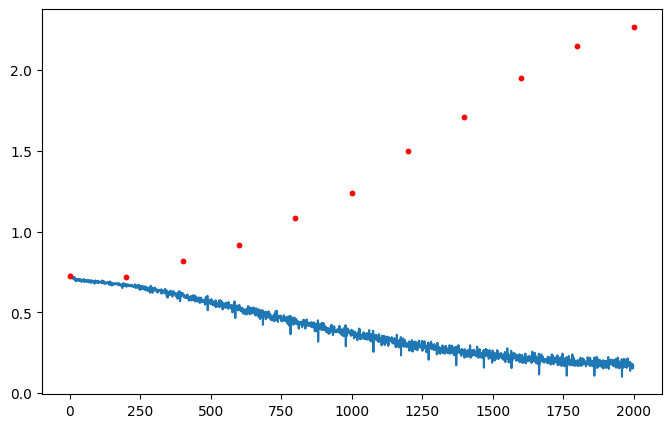

In [60]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.scatter(np.arange(len(valid_losses))*val_loss_n_steps, valid_losses, color='red', zorder=3, s=10)
# plt.scatter(np.arange(len(valid_losses_with_adapter))*val_loss_n_steps, valid_losses_with_adapter, color='green', zorder=3, s=10)
plt.show()

# Save the model

In [61]:
checkpoint = {
    'model': reg_model.state_dict(),
    'config': config
}
# torch.save(checkpoint, MODEL_PATH/f"{MODEL_NAME}.pt")

----
# Validation

In [62]:
@torch.no_grad()
def run_inference_loop(model, dataloader):
    model.eval()
    for batch in dataloader:
        features, _, targets, _, eras, _ = batch
        features = features.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            t_predictions, _ = reg_model(features)

        predictions = t_predictions.squeeze(-1).float().cpu()

    return predictions, targets, eras

In [63]:
def train_adapter_during_inference(mlp_backbone, config, dataloader, loss_fn, n_epochs, era):
    backbone = MlpBackbone(config).to(device)
    backbone.load_state_dict(mlp_backbone.state_dict())

    backbone_with_adapter = MlpBackboneWithAdapter(backbone, config)
    model = MlpReconstructWithAdapterAndConsistency(backbone, backbone_with_adapter, config).to(device)

    optimizer = configure_optimizer(model, weight_decay, learning_rate, betas, device, print_=False)

    model.train(True)
    for epoch in range(n_epochs):
        for batch in dataloader:
            t0 = time.time()
            optimizer.zero_grad()
            xb1, xb2, _, _, _, _ = batch
            xb1, xb2 = xb1.to(device), xb2.to(device)

            with torch.autocast(device_type=device, dtype=dtype):
                xb_hat, mask, h_orig, h_adapt = model(xb1)
                loss = loss_fn(xb_hat, xb1, mask, h_orig, h_adapt, lambda_=0.2)

            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            t1 = time.time()
            dt = t1 - t0
        print(f"[{model.__class__.__name__}] era {str(era).zfill(4)} | epoch {epoch+1:3d}/{n_epochs:3d} | loss={loss.item():.6f}")

    return model

In [64]:
def run_inference_with_adapter_model(model, config, dataloader, n_adapter_epochs, era):
    adapter_model = train_adapter_during_inference(model.backbone, config, dataloader, masked_mse_loss_with_consistency, n_adapter_epochs, era)
    reg_model_with_adapter = MlpRegressionWithAdapterModel(adapter_model.backbone_with_adapter, model.head).to(device)
    inference_data = run_inference_loop(reg_model_with_adapter, dataloader)
    return reg_model_with_adapter, inference_data

In [65]:
reg_model.eval()

MlpRegressionModel(
  (backbone): MlpBackbone(
    (embedding): Linear(in_features=705, out_features=256, bias=True)
    (layers): ModuleList(
      (0-3): 4 x MlpBlock(
        (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (c_fc): Linear(in_features=256, out_features=256, bias=True)
        (c_proj): Linear(in_features=256, out_features=256, bias=True)
        (gelu): GELU(approximate='none')
        (dropout): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (head): RegressionHead(
    (main_proj): Linear(in_features=256, out_features=1, bias=True)
    (aux_proj): Linear(in_features=256, out_features=8, bias=True)
  )
)

In [66]:
train_predictions = []
train_targets = []
used_train_eras = []

inference_train_eras = list(inference_train_dataset.era_to_pairs.keys())
for era in inference_train_eras:
    inference_train_dataset.set_era(era)

    reg_model_with_adapter, inference_data = run_inference_with_adapter_model(
        reg_model, config, inference_train_loader, 5, era)

    predictions, targets, eras = inference_data
    train_predictions.append(predictions.numpy())
    train_targets.append(targets.numpy())
    used_train_eras.append(eras.numpy())

train_predictions = np.concatenate(train_predictions, axis=0)
train_targets = np.concatenate(train_targets, axis=0)
used_train_eras = np.concatenate(used_train_eras, axis=0)

[MlpReconstructWithAdapterAndConsistency] era 0500 | epoch   1/  5 | loss=0.686289
[MlpReconstructWithAdapterAndConsistency] era 0500 | epoch   2/  5 | loss=0.636803
[MlpReconstructWithAdapterAndConsistency] era 0500 | epoch   3/  5 | loss=0.603418
[MlpReconstructWithAdapterAndConsistency] era 0500 | epoch   4/  5 | loss=0.562411
[MlpReconstructWithAdapterAndConsistency] era 0500 | epoch   5/  5 | loss=0.537998
[MlpReconstructWithAdapterAndConsistency] era 0501 | epoch   1/  5 | loss=0.683399
[MlpReconstructWithAdapterAndConsistency] era 0501 | epoch   2/  5 | loss=0.632391
[MlpReconstructWithAdapterAndConsistency] era 0501 | epoch   3/  5 | loss=0.593948
[MlpReconstructWithAdapterAndConsistency] era 0501 | epoch   4/  5 | loss=0.554123
[MlpReconstructWithAdapterAndConsistency] era 0501 | epoch   5/  5 | loss=0.535622
[MlpReconstructWithAdapterAndConsistency] era 0502 | epoch   1/  5 | loss=0.686999
[MlpReconstructWithAdapterAndConsistency] era 0502 | epoch   2/  5 | loss=0.637865
[Mlp

In [67]:
df_train_preds = pd.DataFrame(
    data = {
        'era': [str(era).zfill(4) for era in used_train_eras],
        'target': train_targets,
        MODEL_NAME: train_predictions
    }
)

In [68]:
df_train_preds[MODEL_NAME].describe()

,RANK_MLP_SMALL
count,8000.000000
mean,-0.354227
std,3.750492
min,-14.687500
25%,-2.812500
50%,-0.351562
75%,2.140625
max,13.687500


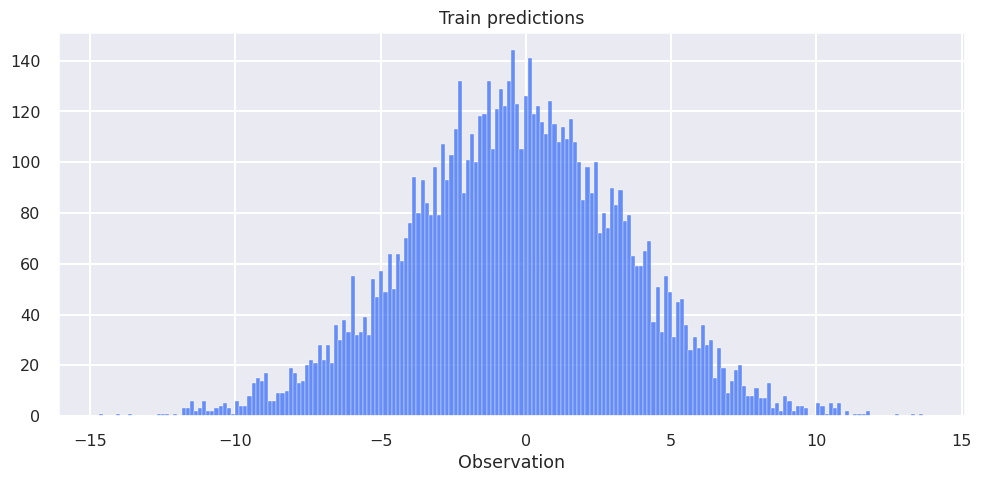

In [69]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.histplot(data=df_train_preds, x=MODEL_NAME, bins=200)

# Customize the plot to match your original settings
plt.title("Train predictions")
plt.xlabel('Observation')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

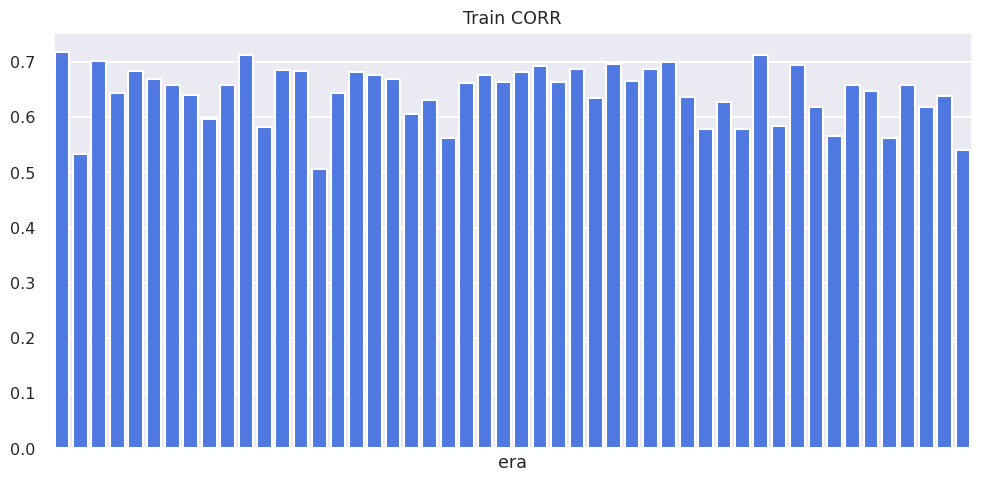

In [70]:
per_era_corr = df_train_preds.groupby("era").apply(
    lambda x: numerai_corr(x[[MODEL_NAME]].dropna(), x['target'].dropna()),
    include_groups=False
)

sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.barplot(data=per_era_corr, x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Train CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

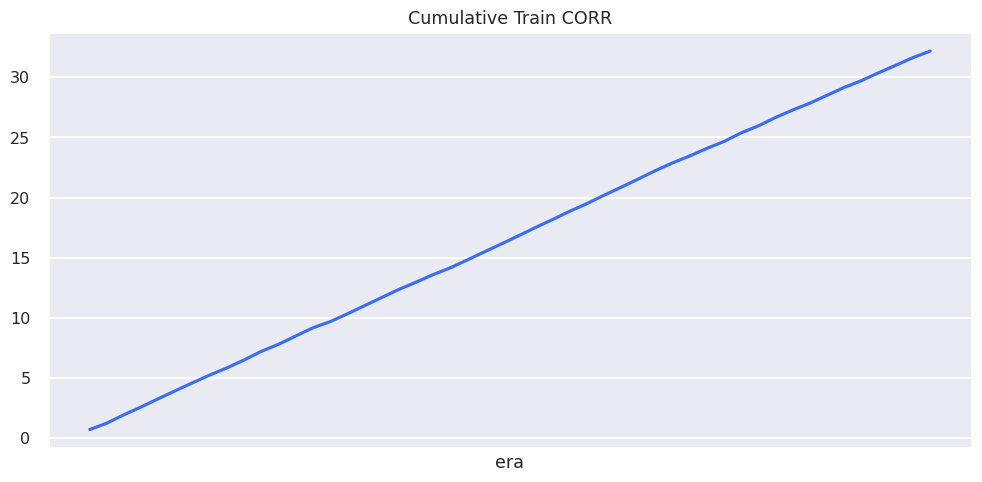

In [71]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.lineplot(data=per_era_corr.cumsum(), x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Cumulative Train CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

----

In [72]:
valid_predictions = []
valid_targets = []
used_valid_eras = []

inference_valid_eras = list(inference_valid_dataset.era_to_pairs.keys())
for era in inference_valid_eras:
    inference_valid_dataset.set_era(era)

    reg_model_with_adapter, inference_data = run_inference_with_adapter_model(
        reg_model, config, inference_valid_loader, 5, era)

    predictions, targets, eras = inference_data
    valid_predictions.append(predictions.numpy())
    valid_targets.append(targets.numpy())
    used_valid_eras.append(eras.numpy())

valid_predictions = np.concatenate(valid_predictions, axis=0)
valid_targets = np.concatenate(valid_targets, axis=0)
used_valid_eras = np.concatenate(used_valid_eras, axis=0)

[MlpReconstructWithAdapterAndConsistency] era 0975 | epoch   1/  5 | loss=0.700381
[MlpReconstructWithAdapterAndConsistency] era 0975 | epoch   2/  5 | loss=0.656177
[MlpReconstructWithAdapterAndConsistency] era 0975 | epoch   3/  5 | loss=0.619139
[MlpReconstructWithAdapterAndConsistency] era 0975 | epoch   4/  5 | loss=0.597139
[MlpReconstructWithAdapterAndConsistency] era 0975 | epoch   5/  5 | loss=0.571052
[MlpReconstructWithAdapterAndConsistency] era 0976 | epoch   1/  5 | loss=0.695676
[MlpReconstructWithAdapterAndConsistency] era 0976 | epoch   2/  5 | loss=0.661808
[MlpReconstructWithAdapterAndConsistency] era 0976 | epoch   3/  5 | loss=0.625381
[MlpReconstructWithAdapterAndConsistency] era 0976 | epoch   4/  5 | loss=0.588149
[MlpReconstructWithAdapterAndConsistency] era 0976 | epoch   5/  5 | loss=0.570430
[MlpReconstructWithAdapterAndConsistency] era 0977 | epoch   1/  5 | loss=0.703778
[MlpReconstructWithAdapterAndConsistency] era 0977 | epoch   2/  5 | loss=0.661670
[Mlp

In [73]:
df_validation_preds = pd.DataFrame(
    data = {
        'era': [str(era).zfill(4) for era in used_valid_eras],
        'target': valid_targets,
        MODEL_NAME: valid_predictions
    }
).dropna()

In [74]:
df_validation_preds[MODEL_NAME].describe()

,RANK_MLP_SMALL
count,3680.000000
mean,-0.540410
std,3.643481
min,-15.437500
25%,-2.890625
50%,-0.527344
75%,1.892578
max,10.437500


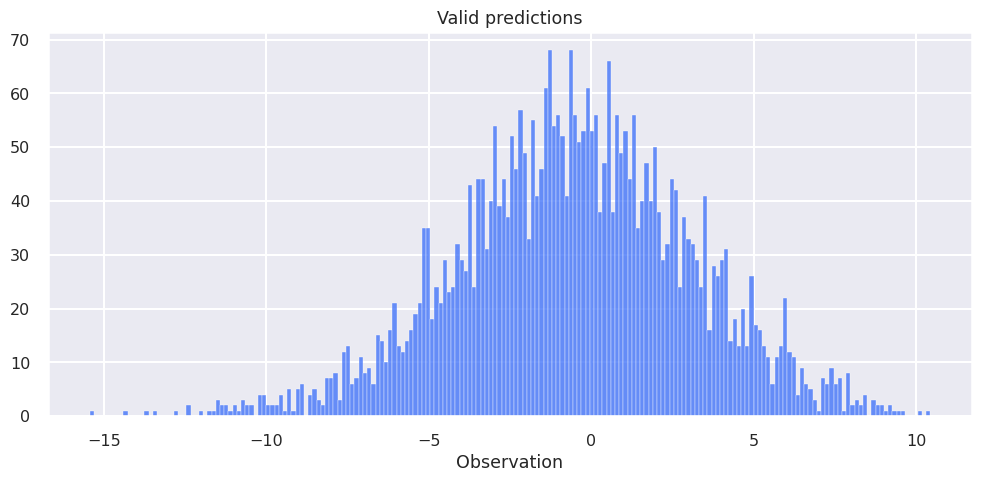

In [78]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.histplot(data=df_validation_preds, x=MODEL_NAME, bins=200)

# Customize the plot to match your original settings
plt.title("Valid predictions")
plt.xlabel('Observation')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

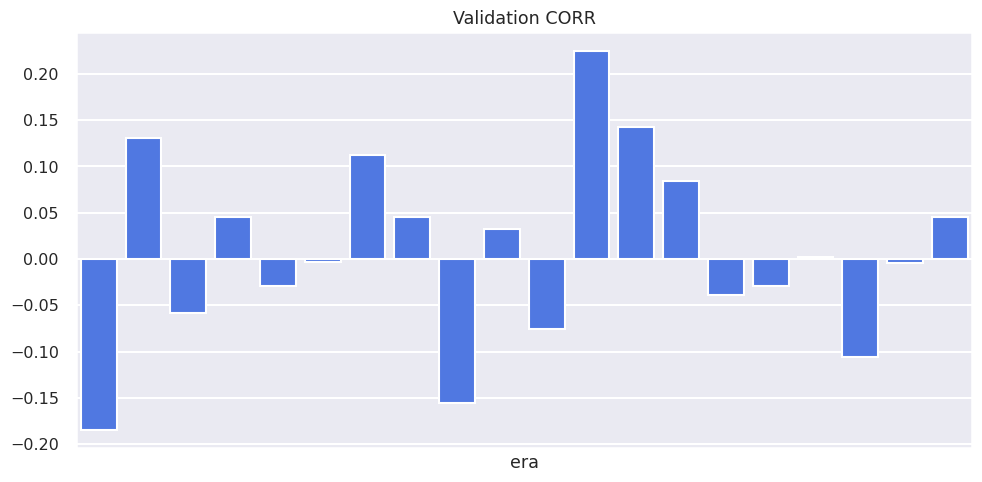

In [75]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = df_validation_preds.groupby("era").apply(
    lambda x: numerai_corr(x[[MODEL_NAME]].dropna(), x['target'].dropna()),
    include_groups=False
)

sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.barplot(data=per_era_corr, x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Validation CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

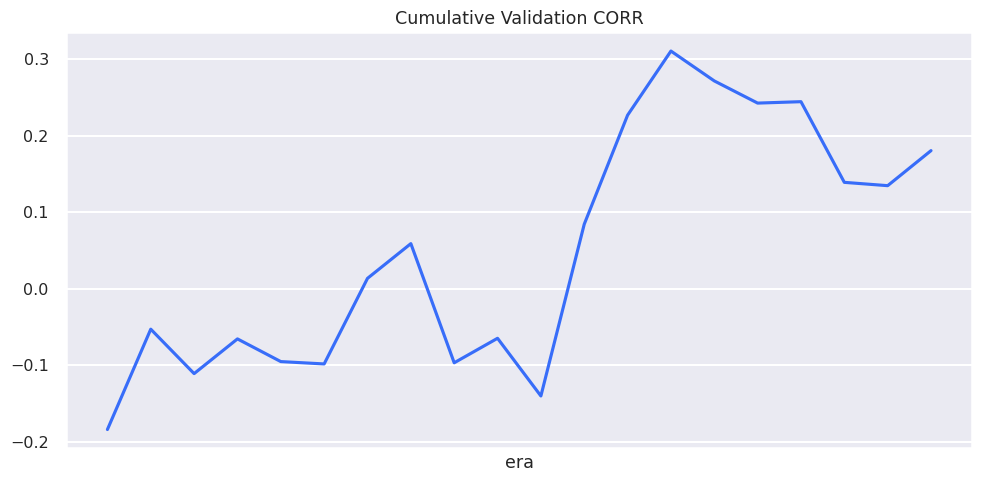

In [76]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.lineplot(data=per_era_corr.cumsum(), x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Cumulative Validation CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [77]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean.values[0]],
    "std": [corr_std.values[0]],
    "sharpe": [corr_sharpe.values[0]],
    "max_drawdown": [corr_max_drawdown.values[0]]
}, index=["CORR"]).T

,CORR
mean,0.009025
std,0.098708
sharpe,0.091428
max_drawdown,0.199224
